This document is part of my [Python visualization library comparison](http://www.terran.us/articles/python_visualization.html)

# Setup and Notes

Note that you must install vega, which is _not_ a pip dependency of altair.

This was a decent intro: https://cmdlinetips.com/2018/04/an-introduction-to-altair-a-python-visualization-library/

Reference docs are here: https://altair-viz.github.io/

In [1]:
import numpy as np
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

from plotnine.data import diamonds

## Data Size

There is a default limit of 5000 rows, because Altair stores the data as JSON inside the notebook.  Using the full diamonds dataset caused this notebook to be 68 MB, which was not practical to work with.  
https://altair-viz.github.io/user_guide/faq.html#why-does-altair-lead-to-such-extremely-large-notebooks

Another option is to write out the data to a separate file, so it's not stored in the notebook:  
https://altair-viz.github.io/user_guide/data_transformers.html  
http://nbviewer.jupyter.org/github/altair-viz/altair-tutorial/blob/master/notebooks/03-Binning-and-aggregation.ipynb#Aside:-How-Altair-Encodes-Data

We'll use the latter approach here.  Note that because of that, we can't call .interactive() on the plots as I would normally do when using Altair — we'll be rendering fixed plots instead, so that when you load the notebook, you'll be able to see them without having the data files available.

In [2]:
#alt.data_transformers.enable("default", max_rows=60000);
alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

##  Open Issues
- Figure out how to make categorical scales use the ordering in the Pandas data instead of going alphabetically.  There is an [open bug](https://github.com/altair-viz/altair/issues/245) for this behavior.

# Two Continuous Dimensions

## Basic Scatter Plot

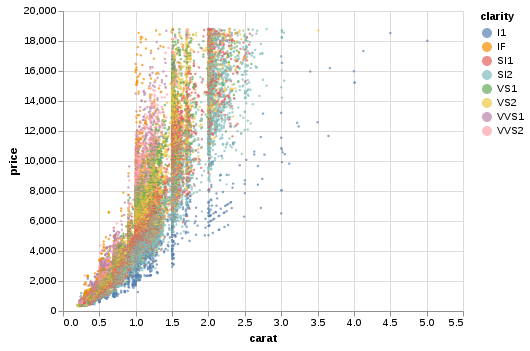

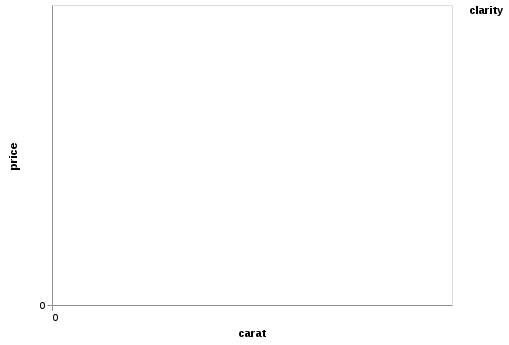

In [3]:
alt.Chart(diamonds).mark_circle(size=6).encode(
  x='carat', y='price', color='clarity')

Note that the legend has been resorted alphabetically, losing the Category ordering.  __TODO:__ figure out how to prevent that.

Also note that the plot can be panned and zoomed with the mouse, but that this particular one is slow to respond because 50k data points is more than Altair can handle well.  That's what I get for changing the 5000 row limit.

## Faceted Scatter Plot

Note that with Altair, we can't _wrap_ the facets - we're limited to specifying something for rows or columns separately.  This is like ggplot's facet_grid, with no equivalent to facet_wrap.

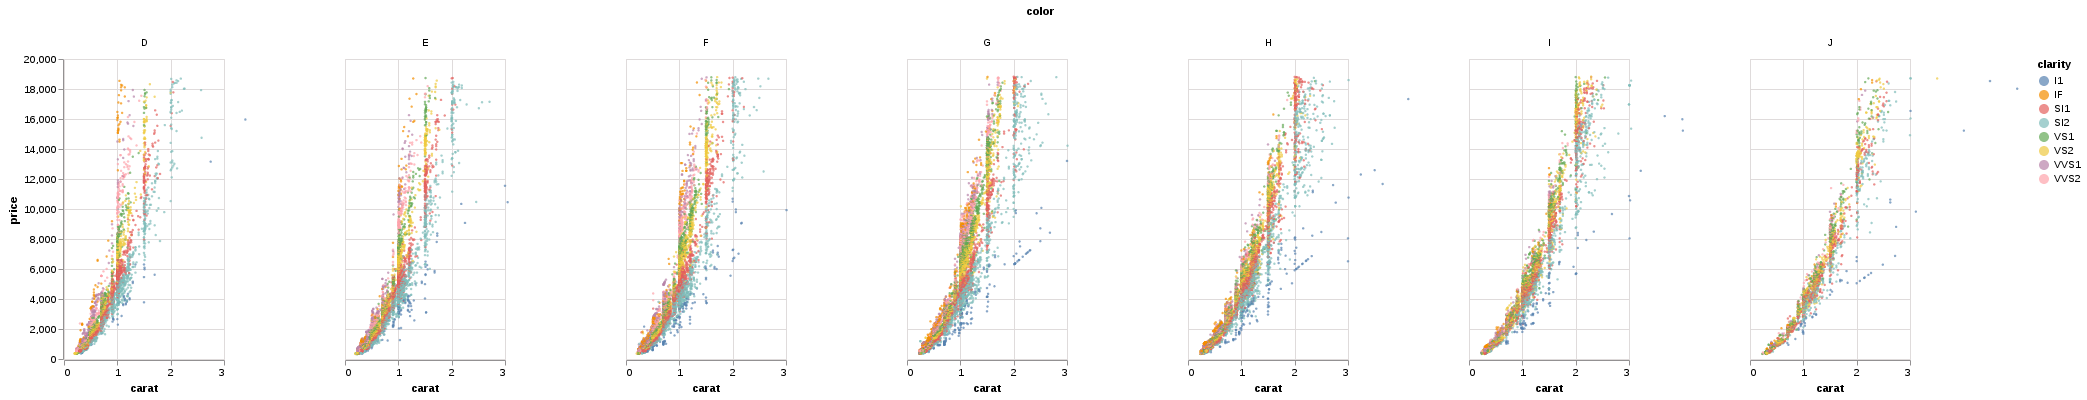

In [4]:
from altair import datum
alt.Chart(diamonds).mark_circle(size=6).encode(
  x=alt.X('carat',scale=alt.Scale(domain=[0,3])), y='price', color='clarity'
).properties(width=160).facet(column='color'
)

## Basic Line Graph

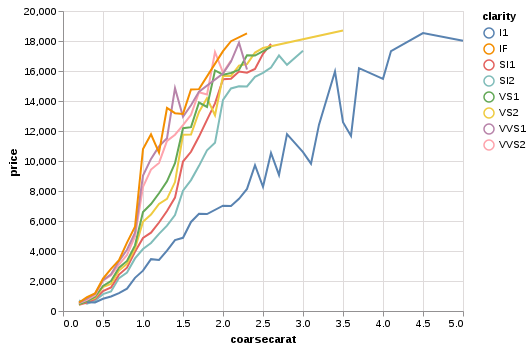

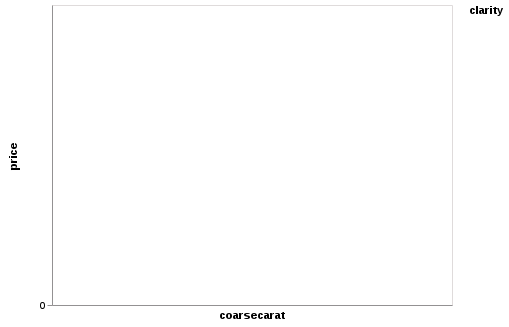

In [5]:
d=diamonds.copy()
d['coarsecarat']=d['carat'].round(1)
d=d.groupby(['coarsecarat','clarity']).aggregate({'price':'mean'}).reset_index()
alt.Chart(d).mark_line().encode(
  x='coarsecarat',y='price',color='clarity')

## Log Scale

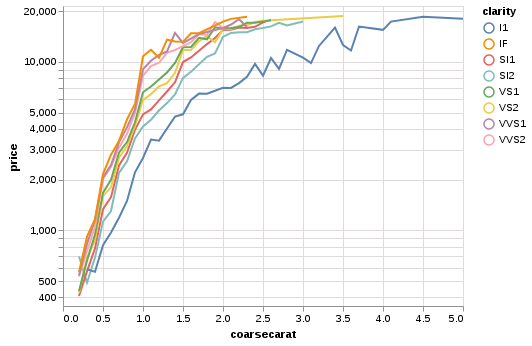

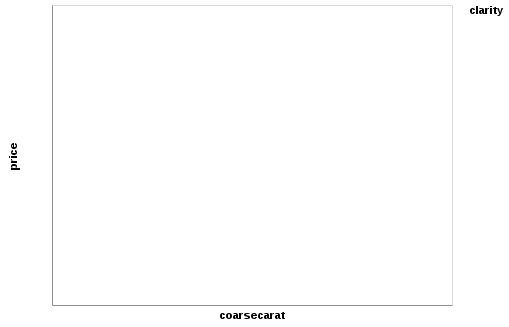

In [6]:
# Without "nice", the scales want to start and end on a power of 10, which leaves too much empty
# space.  I would prefer to make them end on SOME tickmark but not a power of 10, but I haven't been
# able to figure out how to do that, so for now I have just turned off the extension with nice
# entirely and then added some padding to make up for it.

alt.Chart(d).mark_line().encode(
    x='coarsecarat',
    y=alt.Y('price', scale=alt.Scale(type='log',nice=False,padding=10)),
    color='clarity'
)

## Heat Map

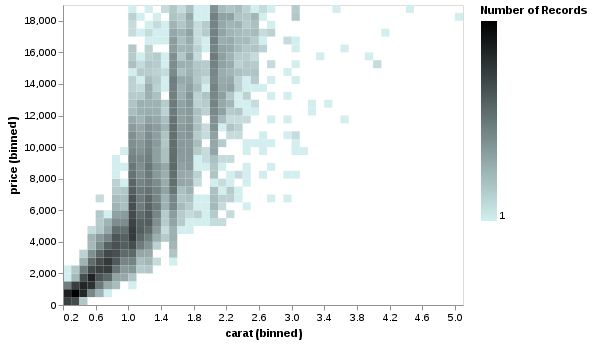

In [7]:
# Getting the colors to play nicely was hard.  It works to alt.Scale(scheme='greenblue') for
# better colors, or alt.Scale(type='log'), but when I set both together, the colors no longer
# work!  In fact, setting _any_ value for type breaks the use of scheme, even if I set it to the
# default, 'linear', but if I manually set the color range, it works fine.

alt.Chart(diamonds).mark_rect().encode(
    x=alt.X('carat',bin=alt.Bin(step=0.1)),
    y=alt.Y('price',bin=alt.Bin(maxbins=50)),
    color=alt.Color('count()',
        scale=alt.Scale(type='log',range=['#D0F0F0','black']))
)

It looks like there's a bug for bad default range on log scales, which might be fixed in a later version than what Altair is using:
https://github.com/vega/vega-lite/issues/4037

Also note that the default color scale, before I changed it, has the lowest counts darkest.  This is bad against a white background: you want the low counts to be the least visually distinguished, not the most.  The default Viridis scale is badly chosen in this regard; ggplot has the same issue.

I finally gave up and asked about Schemes on stack overflow: https://stackoverflow.com/questions/52906275/use-of-color-scheme-with-log-scales

# One Continuous Dimension

## Histogram

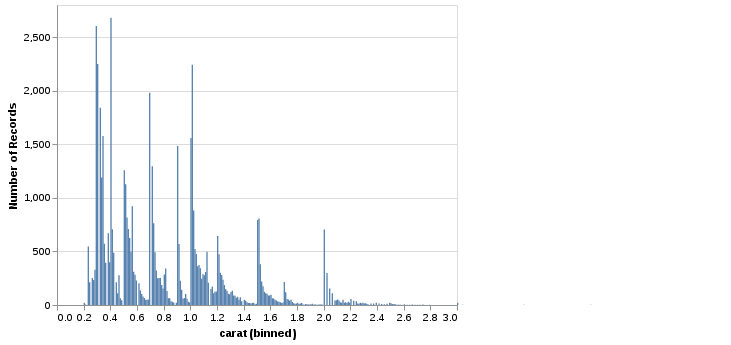

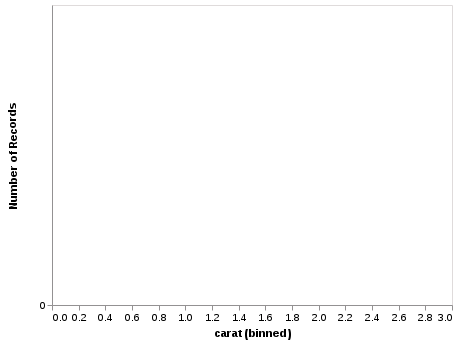

In [8]:
# binSpacing=0 is required to get rid of a blank pixel in between bins, which doesn't work
# when the bins are this close together.

alt.Chart(diamonds).mark_bar(binSpacing=0).encode(
    x=alt.X('carat',bin=alt.Bin(step=0.01), scale=alt.Scale(domain=[0,3])),
    y='count()')

# Two Discrete Dimensions

## Side-by-Side Bar Chart

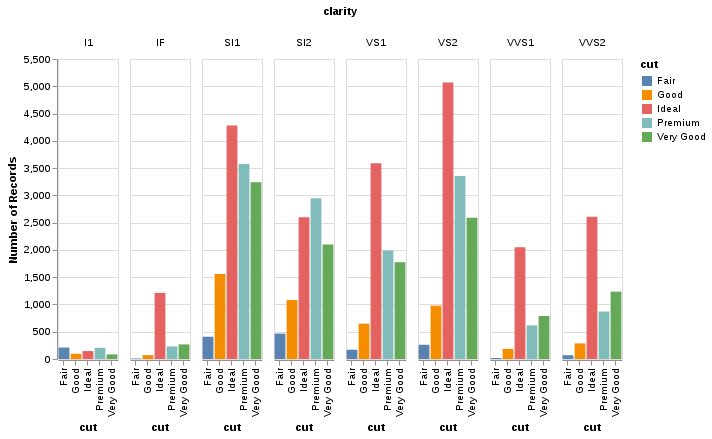

In [9]:
# the stacked bar chart is easy, but getting a NON-stacked bar chart turns out to be
# surprisingly difficult in Altair - it has to be done with faceting:
# https://altair-viz.github.io/gallery/grouped_bar_chart.html

# This is a minimal implementation, without the example's cleanup to remove the
# space and lines in between facets:
alt.Chart(diamonds, width=60).mark_bar().encode(
    x='cut',color='cut',y='count()',column='clarity'
)

## Stacked Bar Chart

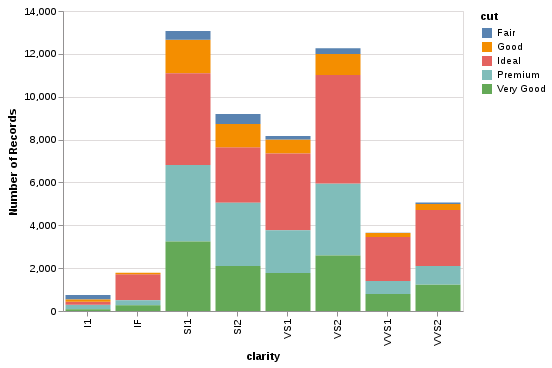

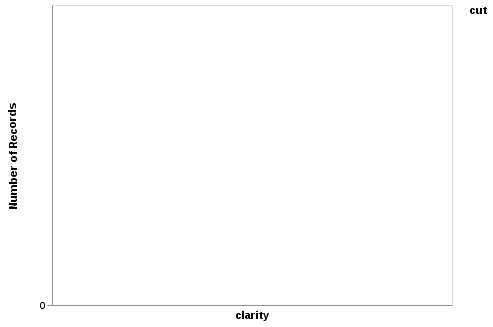

In [10]:
# Just like with ggplot, stacked is the default, so this is very straightforward:

alt.Chart(diamonds, width=400).mark_bar().encode(
    x='clarity',color='cut',y='count()')

# One Discrete, One Continuous

## Boxplot (MARGINAL)

Altair does not have a built-in boxplot.  There is an example showing how to hack it together yourself:  
https://altair-viz.github.io/gallery/boxplot_max_min.html  
This lacks the traditional outlier points ouside the IQR - the whiskers go all the way to the extrema.

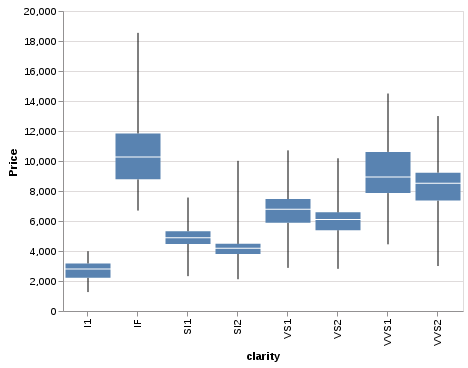

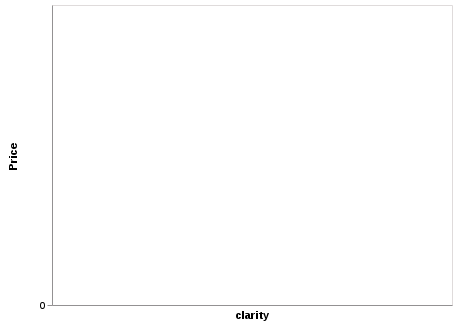

In [11]:
# I have distilled this example down to the minimum
minstr='min(price):Q'
q1str='q1(price):Q'
q3str='q3(price):Q'
maxstr='max(price):Q'

d=diamonds.query('carat >= 0.95 & carat <= 1.05')
lower = alt.Chart(d).mark_rule().encode(
    x='clarity',
    y=minstr, y2=q1str)
middle = alt.Chart(d).mark_bar().encode(
    x='clarity',
    # If any element has an explicit axis label, that label is used.
    y=alt.Y(q1str,axis={'title':'Price'}), y2=q3str)
upper = alt.Chart(d).mark_rule().encode(
    x='clarity',
    y=maxstr, y2=q3str)

# The tick width is not automatically set correctly and has to be adjusted
tick = alt.Chart(d).mark_tick(color='white', size=50).encode(
    x='clarity',y='median(price):Q')

(lower + middle + upper + tick).properties(width=400)

That almost worked, but the order of the clarity values __has__ to be fixed to use the ordering of the Category; it's just unusable here in alphabetical order.

## Violin Plot (FAIL)

Violin plots are not available in Altair.  Obviously you could make one manually, but I'm not going to take the time to do that now.

## Faceted Histogram

As before, we have the limitation that facets can't be wrapped; a single faceting variable must put them all in a row or column.

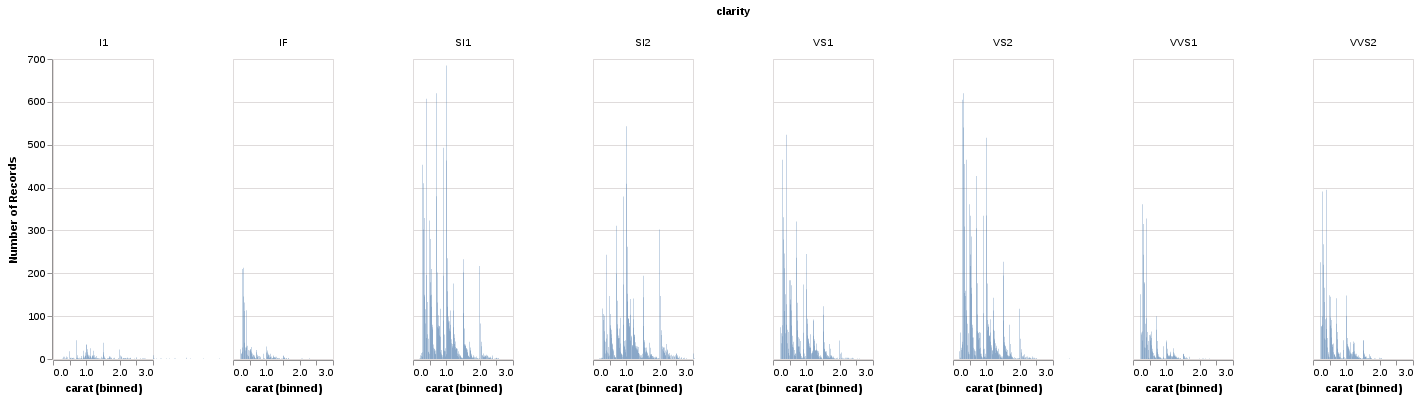

In [12]:
alt.Chart(diamonds,width=100).mark_bar(binSpacing=0).encode(
    x=alt.X('carat',bin=alt.Bin(step=0.01), scale=alt.Scale(domain=[0,3])),
    y='count()',
    column='clarity'
)

# More Than Two Variables

## Pairs Plot

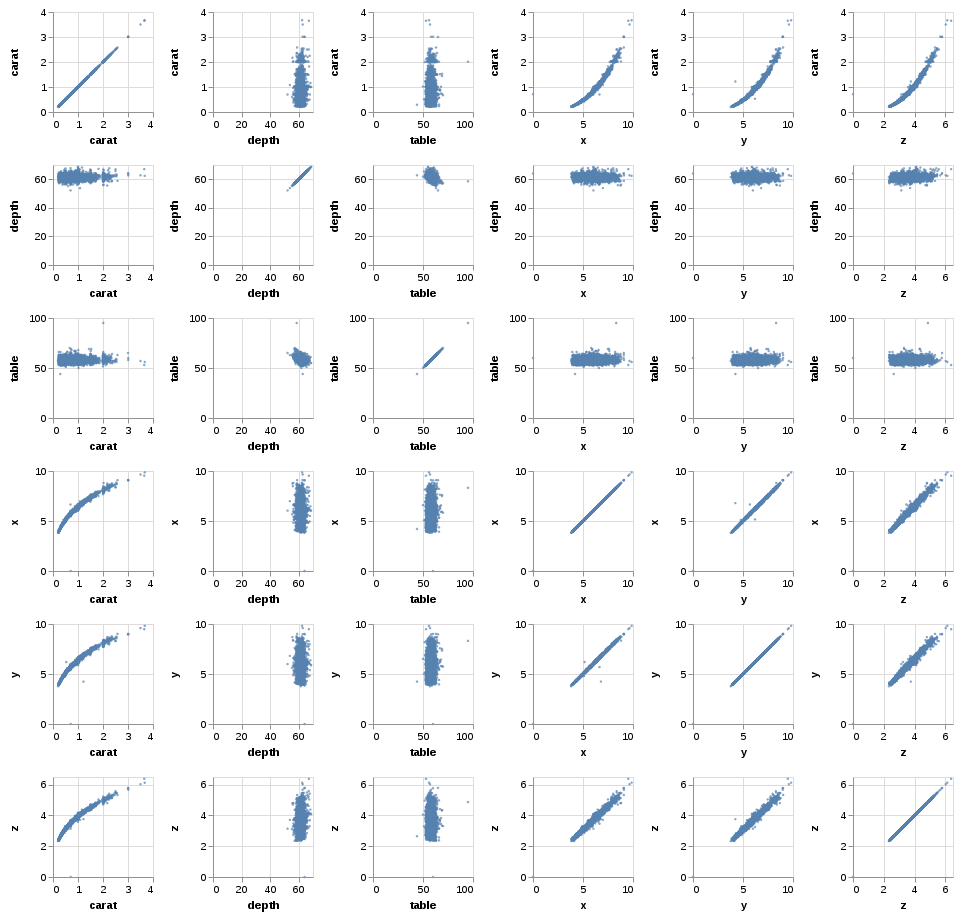

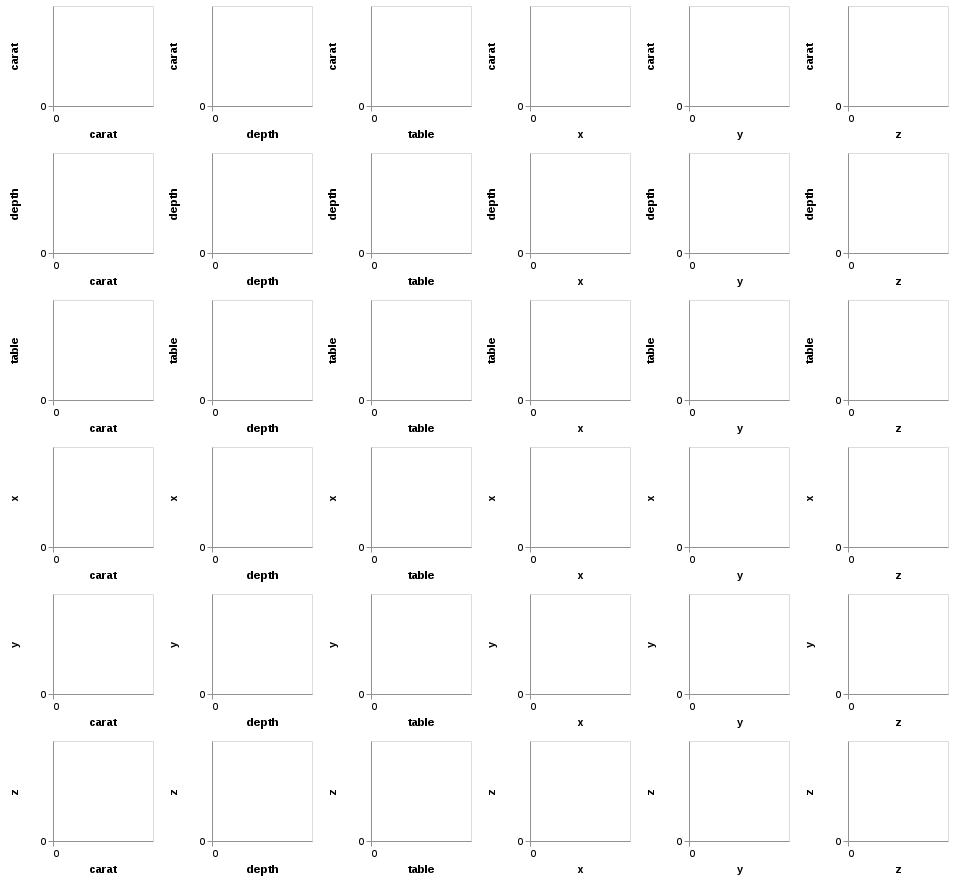

In [13]:
numeric_cols=[d for d in diamonds.columns if diamonds[d].dtype==np.float64]

# Here I subsample diamonds, otherwise it's impossibly slow and bloated.
alt.Chart(diamonds.sample(5000), height=100, width=100).mark_circle(size=6).encode(
    x=alt.X(alt.repeat('column'), type='quantitative'),
    y=alt.Y(alt.repeat('row'), type='quantitative')
).repeat(
    row=numeric_cols, column=numeric_cols
)

Can we now do the same thing for the categorical variables?

In [14]:
categorical_cols=[d for d in diamonds.columns if diamonds[d].dtype!=np.float64]

# You'd think this would work, but it doesn't - produces a Javascript error which I can't debug
# because this page is so bloated the JS console won't open.

#alt.Chart(diamonds.sample(5000), height=100, width=100).mark_bar().encode(
#    x=alt.X(alt.repeat('column'), type='nominal'),
#    color=alt.Y(alt.repeat('row'), type='nominal'),
#    y='count()'
#).repeat(
#    row=categorical_cols, column=categorical_cols
#).interactive()